**DBM: ассоциативная память**

Евгений Борисов <esborisov@sevsu.ru>

Ассоциативная память на основе ограниченной машины Больцмана (RBM).   
http://mechanoid.su/neural-net-boltzman-restr.html

Deep Boltzmann Machines (DBMs) in Deep Learning   
https://www.geeksforgeeks.org/deep-boltzmann-machines-dbms-in-deep-learning/

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

#  загружаем данные 

In [2]:
# !ls data

In [3]:
import pickle
import gzip

# with gzip.open('data/pix-17x31.pkl.gz','rb') as f: data = pickle.load(f)
# data_train = data['train']['data']
# data_test = data['test']['data']

with gzip.open('data/abc-29x29.pkl.gz','rb') as f: data = pickle.load(f)   
data_train = data['train']['data']*255
target_train =  data['train']['target']
data_test = data['test']['3d']['data'].mean(axis=-1).astype(np.uint8)
data_test = (data_test>180).astype(np.uint8)*255
target_test =  data['test']['3d']['target']

# with gzip.open('data/numb-30x30.pkl.gz','rb') as f: data = pickle.load(f)
# data_train = data['train']['data']
# target_train =  data['train']['target']-1
# data_test = data['test']['noise_lo']['data']
# target_test =  data['test']['noise_lo']['target']-1

del data

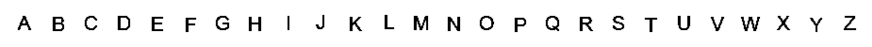

In [4]:
fig, ax = plt.subplots( 1, len(data_train), figsize=(min(11,len(data_train)),5))
for c in range(len(data_train)): 
    ax[c].axis('off')
    ax[c].imshow(data_train[c],cmap='gray') #,cmap='GnBu')

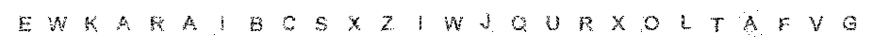

In [5]:
data_test_ = data_test[rng.permutation(len(data_test))[:len(data_train)]]
fig, ax = plt.subplots( 1, len(data_test_), figsize=(min(11,len(data_test_)),5))
for c in range(len(data_test_)): 
    ax[c].axis('off')
    ax[c].imshow(data_test_[c],cmap='gray')

## формируем датасет

In [6]:
n,w,h = data_train.shape
x_train = ( (data_train<(data_train.max()/2)).astype(float) ).reshape(n,w*h)
display(x_train.shape)

n,w,h = data_test.shape
x_test = ( (data_test<(data_test.max()/2)).astype(float) ).reshape(n,w*h)
display(x_test.shape)

(26, 841)

(234, 841)

# модель

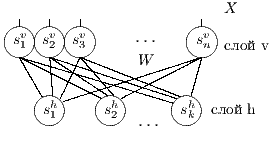

In [7]:
def msqe(t,o):
    d = t-o
    return (d*d).mean()

In [8]:
class RBM:
    
    def __init__(self,v_size,h_size):
        self._weight = rng.normal(size=(v_size,h_size),scale=1e-2)
        self._bias_h = np.zeros(shape=(1,h_size))
        self._bias_v = np.zeros(shape=(1,v_size))
    
    def forward(self,x,max_iter=128,min_delta=1e-4):
        v = x
        for n in range(max_iter):
            v_ = v # сохраняем состояние
            _,v = self._forward_step(v) # переходим в новое состояние
            # если состояние не изменилось то завершаем
            if msqe(v,v_)<min_delta: break
        return n,v        
    
    def _forward_step(self,x):
        h = self._sample_hidden(x)
        v = self._sample_visible(h)
        return h,v
    
    def _sample_hidden(self,v):
        p = self.sigmoid( v.dot(self._weight) - self._bias_h )
        return rng.binomial(1,p)
        
    def _sample_visible(self,h):
        p = self.sigmoid( h.dot(self._weight.T) - self._bias_v )
        return rng.binomial(1,p)
    
    def forward_train(self,x):
        visible = [x]
        hidden = []
        h0 = self._sample_hidden(x)
        v1 = self._sample_visible(h0)
        h1 = self._sample_hidden(v1)
        return np.stack([h0,h1]),np.stack([x,v1])
    
    def forward_hidden(self,x):
        return self._sample_hidden(x)
    
    def forward_visible(self,h):
        return self._sample_visible(h)
    
    @staticmethod
    def sigmoid(x):
        return 1./(1.+np.exp(-x))
    
    @property
    def weight(self):
        return self._weight, self._bias_h, self._bias_v 
        
    @weight.setter
    def weight(self,w): 
        self._weight = w[0]
        self._bias_h = w[1]
        self._bias_v = w[2]
        return self

In [9]:
# model = RBM(v_size=x_train.shape[1],h_size=128)
# n,o = model.forward(x_train)
# display( n, o.shape )

# h,v = model.forward_train(x_train)
# display( h.shape, v.shape )

---

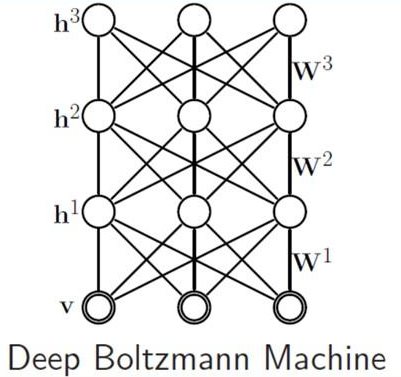

https://russianblogs.com/article/58301936554/

In [10]:
class DBM:
    def __init__(self, layer_sizes):
        self._rbm = [ 
                RBM(layer_sizes[i], layer_sizes[i+1]) 
                for i in range(len(layer_sizes)-1) 
            ]

    def forward(self,x,max_iter=8,min_delta=1e-4):
        v = x
        for n in range(max_iter):
            v_ = v # сохраняем состояние
            v = self._forward_step(v) # переходим в новое состояние
            # если состояние не изменилось то завершаем
            if msqe(v,v_)<min_delta: break
        return n,v  
    
    def _forward_step(self,x):
        h = self._forward_hidden(x)
        v = self._forward_visible(h)
        return v
    
    def _forward_hidden(self,x):
        h = x
        for rbm in self._rbm:
            h = rbm.forward_hidden(h)
        return h
    
    def _forward_visible(self,h):
        v = h
        for rbm in self._rbm[::-1]:
            v = rbm.forward_visible(v)
        return v
    
    @property
    def rbm(self): return self._rbm
    
    @rbm.setter
    def rbm(self,rbm): self._rbm = rbm

In [11]:
# layer_sizes = [ x_train.shape[1], 256,128,64 ]
# model = DBM(layer_sizes)
# n,o = model.forward(x_train)
# display( n, o.shape )

# загружаем память модели

In [12]:
from tqdm.auto import tqdm

In [13]:
class TrainRBM:
        
    def __init__(self,model):
        self._model = model
        self._lr = 1e-1
        self._mu = 0.
        self._rho = 0.
        
        self._dw  = 0.
        self._dbh = 0.
        self._dbv = 0.
    
    def fit(self,x,batch_size,n_epoch=2,lr=1e-1,mu=0.,rho=.0,min_loss=1e-5):
        assert len(x)>1
        assert (0<batch_size<(len(x)+1))
        self._lr = lr
        self._mu = mu
        self._rho = rho
                
        loss_history = []
        for _ in tqdm(range(n_epoch)):
            self._fit_epoch(x,batch_size)
            loss_history.append( self._loss(x) )
            if loss_history[-1]<min_loss: break
                
        return loss_history, self._model
    
    def _fit_epoch(self,x,batch_size):
        for x in self._get_batch(x,batch_size):
            self._fit_batch(x)
        return self
    
    def fit_epoch(self,x,batch_size,lr=1e-1,mu=0.,rho=.0):
        assert len(x)>1
        assert (0<batch_size<(len(x)+1))
        self._lr = lr
        self._mu = mu
        self._rho = rho
        self._fit_epoch(x,batch_size)
        return self._model
        
    def _fit_batch(self,x):
        h,v = self._model.forward_train(x)
        dw,dbh,dbv = self._gradient(h,v)
        self._weight_ajust(dw,dbh,dbv)
        return self
        
        
    def _gradient(self,h,v):
        dw = v[0].T.dot(h[0]) - v[1].T.dot(h[1])
        dbv = (v[0]-v[1]).mean(axis=0)
        dbh = (h[0]-h[1]).mean(axis=0)
        return dw,dbh,dbv
    
    def _weight_ajust(self,dw,dbh,dbv):
        w,bh,bv = self._model.weight
        self._dw  = self._lr*(dw + self._rho*w) +  self._mu * self._dw
        self._dbh = self._lr*(dbh + self._rho*bh) + self._mu * self._dbh
        self._dbv = self._lr*(dbv + self._rho*bv) + self._mu * self._dbv 
        self._model.weight = ( w+self._dw, bh+self._dbh, bv+self._dbv, )
        return self
                    
    # генератор батчей
    def _get_batch(self,x,batch_size): 
        n_samples = len(x) # количество учебных пар
        batch_count = np.ceil( n_samples/batch_size).astype(int) # количество батчей
        # перемешиваем учебный набор и режем его на батчи
        for idx in np.array_split(rng.permutation(n_samples), batch_count ):
            yield x[idx,:]

    def _loss(self,target):
        _,predicted = self._model.forward(target)
        d = (target-predicted)
        return (d*d).mean()


In [14]:
class TrainDBM:
        
    def __init__(self,model):
        self._model = model
        self._lr=1e-1
        self._rho=0.
        self._mu=0.
        self._min_loss=1e-1
        self._n_epoch_pretrain=1
        self._n_epoch_finetune=1
        
        
    def fit(self,x,lr=1e-2,rho=1e-2, mu=4e-1,min_loss=1e-1,n_epoch_pretrain=512,n_epoch_finetune=128):
        self._lr = lr
        self._rho = rho
        self._mu = mu
        self._min_loss = min_loss
        self._n_epoch_pretrain = n_epoch_pretrain
        self._n_epoch_finetune = n_epoch_finetune
        
        loss_history_p = self._pretrain(x)
        loss_history_f = self._finetune(x)
        return (loss_history_p,loss_history_f),self._model
    
    def _pretrain(self,x):
        rbms = self._model.rbm
        rbms_ = []
        x_ = x
        loss_history = []
        for i, rbm in enumerate(rbms):
            print(f'Pretraining RBM Layer {i+1}/{len(rbms)}')
            loss_, rbm_ = self._fit_rbm(rbm,x_)
            rbms_.append(rbm_)
            loss_history.append(loss_)
            x_ = rbms_[-1].forward_hidden(x_)
        self._model.rbm = rbms_
        return loss_history

    
    def _fit_rbm(self,model,x,n_epoch=256*2):
        return TrainRBM(model=model).fit(
                    x,
                    n_epoch=self._n_epoch_pretrain, 
                    batch_size=len(x)//2, 
                    lr=self._lr,
                    rho=self._rho,
                    mu=self._mu,
                    min_loss=self._min_loss,
                )
    
    def _fit_epoch_rbm(self,model,x):
        return TrainRBM(model=model).fit_epoch(
                    x,
                    batch_size=len(x)//2, 
                    lr=self._lr,
                    rho=self._rho,
                    mu=self._mu,
                )
                
    def _finetune(self,x):
        print('Finetune...')
        _,v = self._model.forward(x)
        loss_history = [ msqe(x,v) ]
        
        for _ in tqdm(range(self._n_epoch_finetune)):
            self._finetune_epoch(x)
            _,v = self._model.forward(x)
            loss_history.append( msqe(x,v) )
        return loss_history
            
    
    def _finetune_epoch(self, x):
        rbms = self._model.rbm
        h = [x]
        for rbm in rbms: h.append( rbm.forward_hidden(h[-1]) )
        rbms_ = [] 
        for i in list(reversed(range(0,len(h)-1))):
            rbms_.append( self._fit_epoch_rbm( rbms[i], h[i] ) ) 
        self._model.rbm = rbms_[::-1]
        return self


----

In [15]:
layer_sizes = [ x_train.shape[1], 512,256,128,64 ]
model = DBM(layer_sizes)

(loss_history_p,loss_history_f),model = TrainDBM(model).fit(x_train,min_loss=1e-1,n_epoch_finetune=512)

# n,o = model.forward(x_train)
# display( n, o.shape )

Pretraining RBM Layer 1/4


  0%|          | 0/512 [00:00<?, ?it/s]

Pretraining RBM Layer 2/4


  0%|          | 0/512 [00:00<?, ?it/s]

Pretraining RBM Layer 3/4


  0%|          | 0/512 [00:00<?, ?it/s]

Pretraining RBM Layer 4/4


  0%|          | 0/512 [00:00<?, ?it/s]

Finetune...


  0%|          | 0/512 [00:00<?, ?it/s]

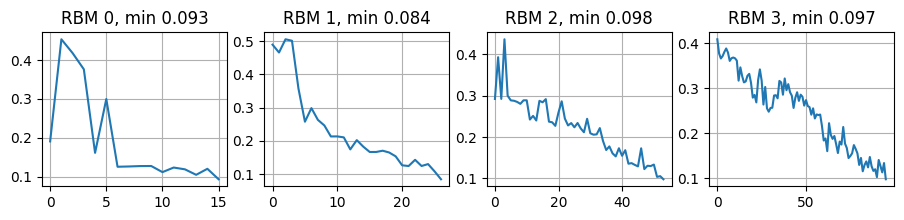

In [16]:
fig,ax = plt.subplots(1,len(loss_history_p),figsize=(11,2))
for n,lh in enumerate(loss_history_p):
    ax[n].plot( lh )
    ax[n].set_title(f'RBM {n}, min {min(lh):.3f}')
    ax[n].grid()
    
# plt.title('pretrain MSQE')

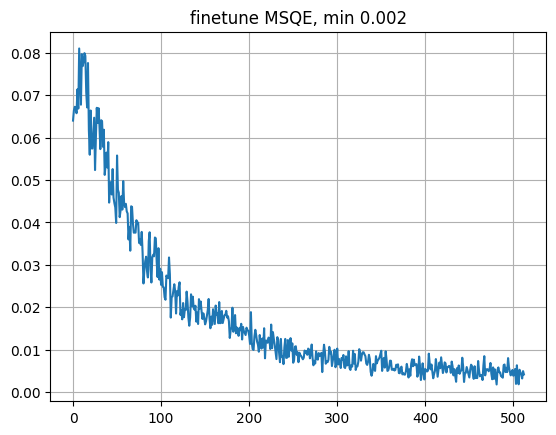

In [17]:
fig,ax = plt.subplots()
ax.plot( loss_history_f )
ax.set_title(f'finetune MSQE, min {min(loss_history_f):.3f}')
ax.grid()

In [18]:
n,o = model.forward(x_train)
display( n, o.shape )

7

(26, 841)

# тестируем

In [19]:
def plot_images_pair(data0,data1,ncols=7):
    assert data0.shape == data1.shape
    
    ncols_ = ncols*2
    nrows = int(np.ceil(len(data0)/ncols))
    
    figsize=(ncols_,nrows)
    fig, ax = plt.subplots( nrows, ncols_, figsize=figsize)
    
    for r in range(nrows): 
        for c in range(0,ncols_,2): 
            ax[r,c].axis('off')
            ax[r,c+1].axis('off')
            
            n = r*ncols+c//2
            if ( n+1 > len(data0) ): continue
                
            ax[r,c].imshow(data0[n],cmap='gray')
            ax[r,c+1].imshow(data1[n],cmap='copper') # summer winter

## учебный набор

In [20]:
o = [
    model.forward(x_train[[i],:],max_iter=16,min_delta=1e-3)
    for i in tqdm(range(len(x_train)))
]

n = [ n for n,_ in o ]
o = np.vstack([ x for _,x in o ])
display(o.shape)

  0%|          | 0/26 [00:00<?, ?it/s]

(26, 841)

In [21]:
# display(n)

In [22]:
(w,h),n = data_train[0].shape,len(data_train)
o_ = ((1-o.reshape(n,w,h))*127).astype(np.uint8)
display(o_.shape)

# MSQE
d = x_train-o
display( (d*d).mean() )

(26, 29, 29)

0.0027439860971371077

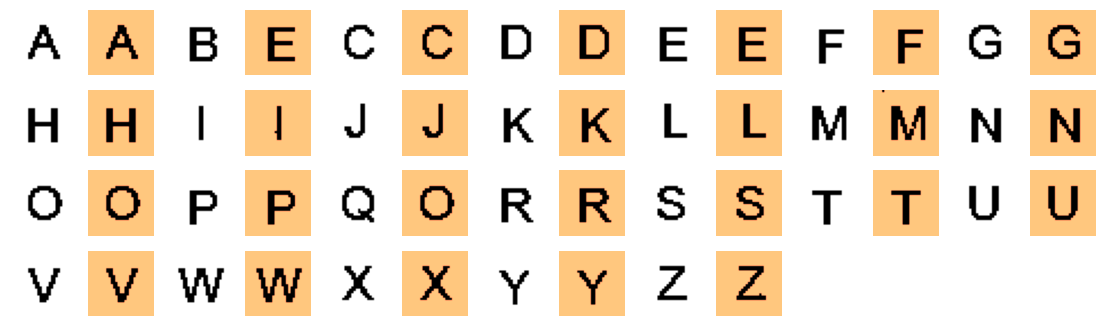

In [23]:
data_train_ = ((1-x_train.reshape(n,w,h))*127).astype(np.uint8)

plot_images_pair(data_train_,o_)

## тестовый набор

In [24]:
o = [
    model.forward(x_test[[i],:],max_iter=8,min_delta=1e-3)
    for i in tqdm(range(len(x_test)))
]

n = [ n for n,_ in o ]
o = np.vstack([ x for _,x in o ])
display(o.shape)

  0%|          | 0/234 [00:00<?, ?it/s]

(234, 841)

In [25]:
# n,o = model.forward(x_test,max_iter=32,min_delta=16e-3)
# display(n)

In [26]:
(w,h),n = data_test[0].shape,len(data_test)
o_ = ((1-o.reshape(n,w,h))*127).astype(np.uint8)
display(o_.shape)

# MSQE
d = x_train[target_test,:]-o
display( (d*d).mean() )

(234, 29, 29)

0.009405774566297752

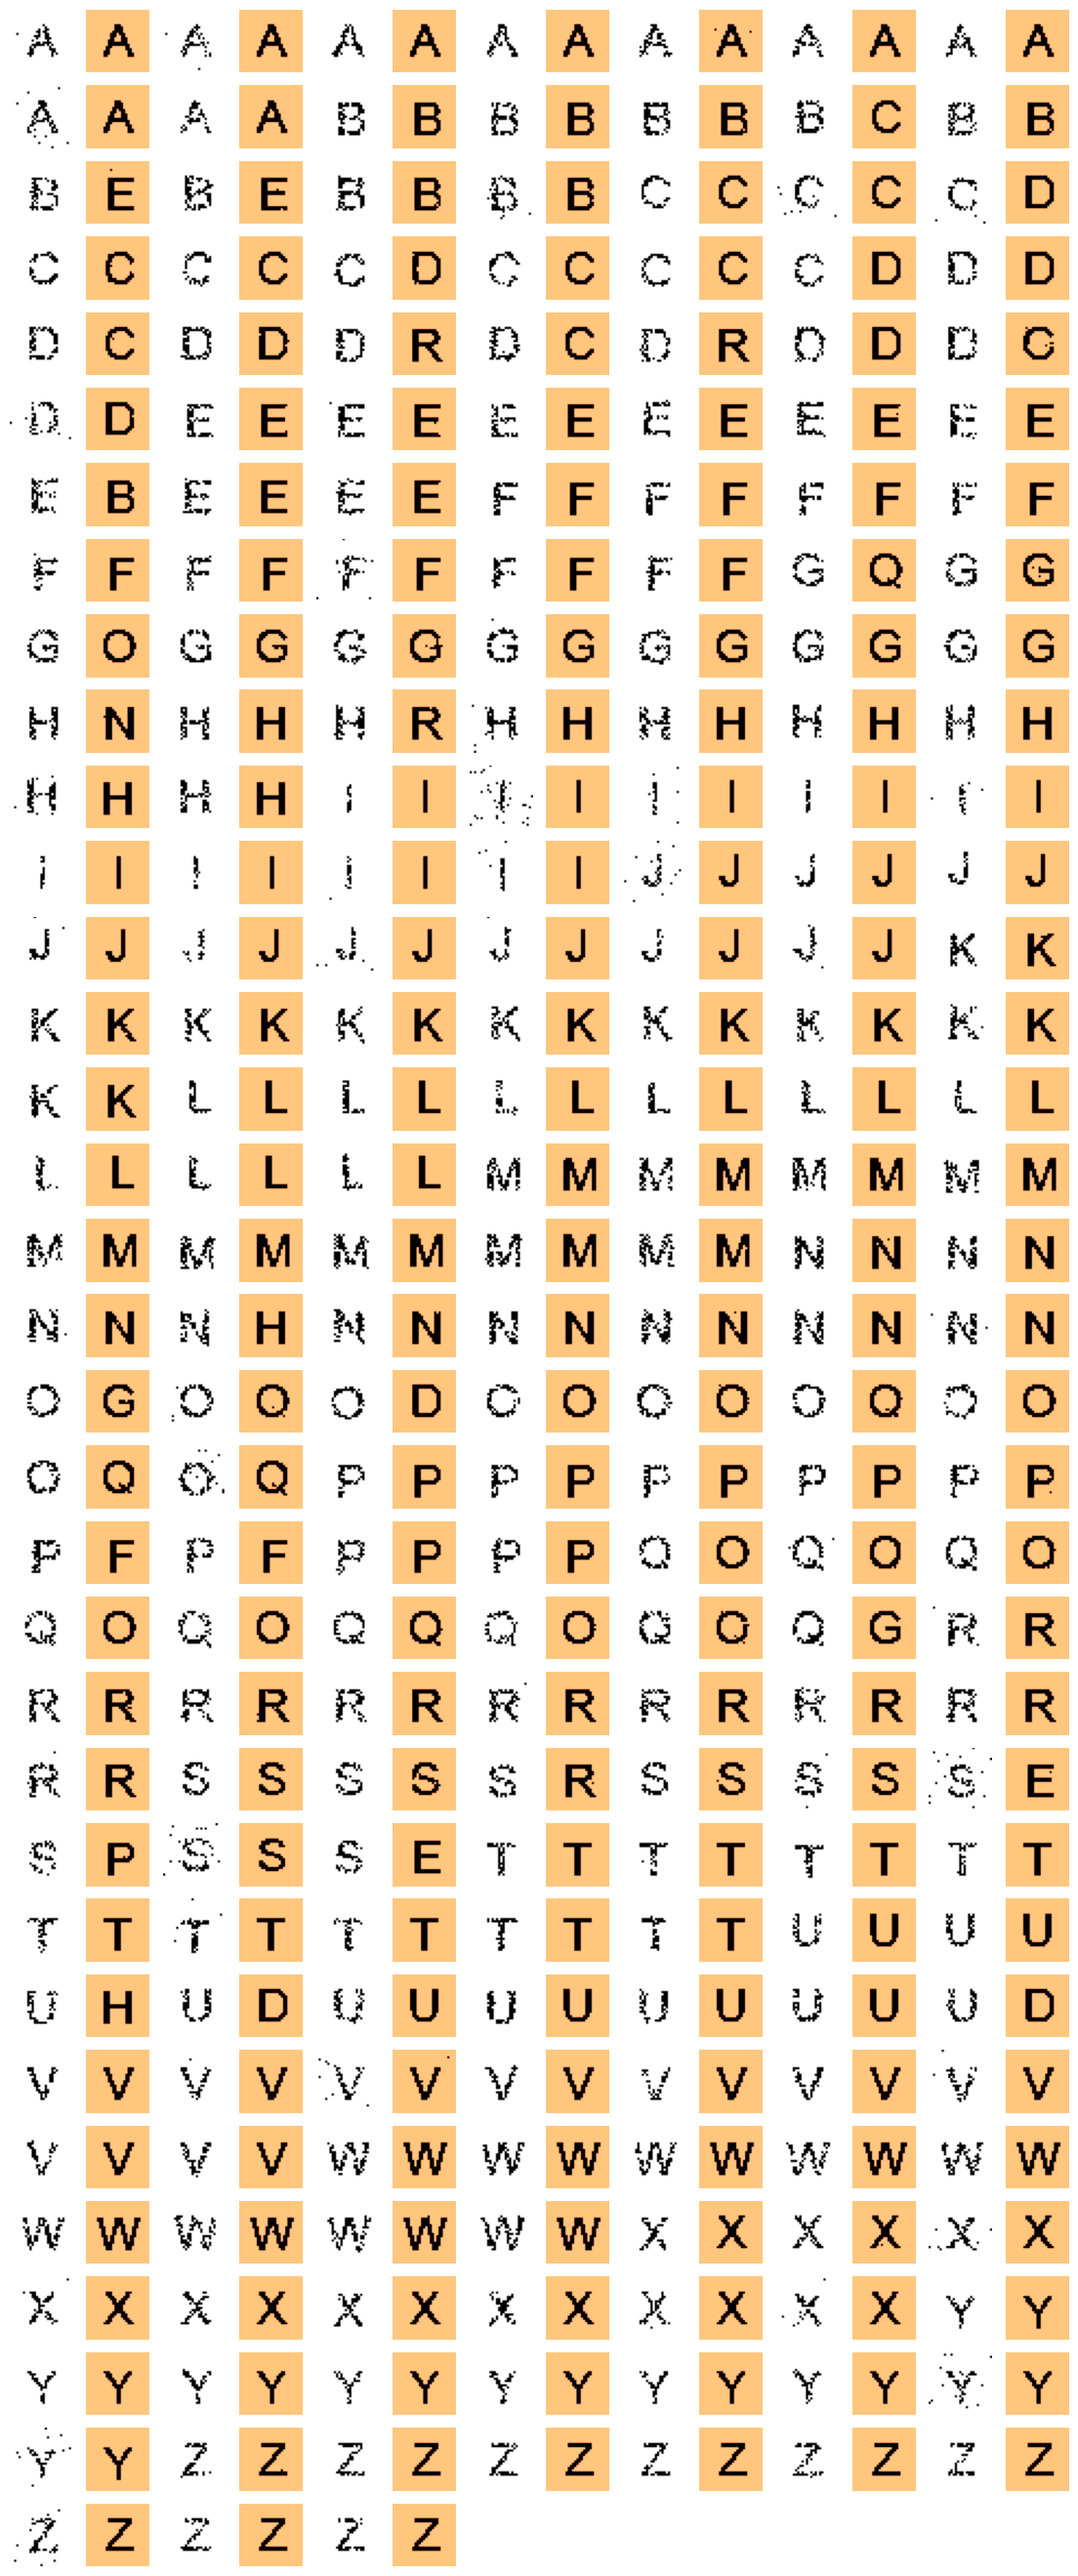

In [27]:
data_test_ = ((1-x_test.reshape(n,w,h))*127).astype(np.uint8)

plot_images_pair(data_test_,o_)